In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings.filterwarnings('ignore')

# Used to read only limited number of rows from dataset
chunk_size = 10 ** 5 # 100.000

## Analyse and process dataset

### Read base book dataset

In [2]:
books_df = pd.read_csv("books.csv", nrows=chunk_size)

# Keep only certain columns
books_df = books_df[["book_id",
                     "authors", 
                     "original_publication_year",
                     "original_title",
                     "average_rating",
                     "image_url"
                    ]]
books_df.head()

,book_id,authors,original_publication_year,original_title,average_rating,image_url
0,1,Suzanne Collins,2008.0,The Hunger Games,4.34,https://images.gr-assets.com/books/1447303603m...
1,2,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,4.44,https://images.gr-assets.com/books/1474154022m...
2,3,Stephenie Meyer,2005.0,Twilight,3.57,https://images.gr-assets.com/books/1361039443m...
3,4,Harper Lee,1960.0,To Kill a Mockingbird,4.25,https://images.gr-assets.com/books/1361975680m...
4,5,F. Scott Fitzgerald,1925.0,The Great Gatsby,3.89,https://images.gr-assets.com/books/1490528560m...


### Search for duplicates

In [3]:
len([
    i 
    for i in books_df.duplicated(subset="original_title")
    if i==True
])

725

### Remove duplicates

In [4]:
books_df.drop_duplicates(subset="original_title", keep="first", inplace=True)

### Verify removal 

In [5]:
len([
    i 
    for i in books_df.duplicated(subset="original_title")
    if i==True
])

0

## Read and process ratings dataset


In [6]:
# Read ratings dataset
ratings_df = pd.read_csv("ratings.csv", nrows=chunk_size)

### Find all the times a book has been rated and merge with main book dataset

In [7]:
# Get ratings for each book
ratings_per_book = pd.DataFrame(ratings_df.groupby("book_id").count()) # Group by book_id
del ratings_per_book["user_id"] # Remove unnecessary column
ratings_per_book.columns = ["times_rated"] # Rename column 
ratings_per_book = ratings_per_book.join(books_df["original_title"])
ratings_per_book.head()

,times_rated,original_title
book_id,,
2,569,Twilight
3,45,To Kill a Mockingbird
4,591,The Great Gatsby
5,585,The Fault in Our Stars
7,365,The Catcher in the Rye


In [8]:
# Breaks down the rating to each of the 5 rating values
#ratings_per_book_per_level = pd.DataFrame(ratings_df.groupby('book_id')['rating'].value_counts())

# Merge with main dataset
books_df = pd.merge(books_df, ratings_per_book['times_rated'], on="book_id")
books_df.head()

,book_id,authors,original_publication_year,original_title,average_rating,image_url,times_rated
0,2,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,4.44,https://images.gr-assets.com/books/1474154022m...,569
1,3,Stephenie Meyer,2005.0,Twilight,3.57,https://images.gr-assets.com/books/1361039443m...,45
2,4,Harper Lee,1960.0,To Kill a Mockingbird,4.25,https://images.gr-assets.com/books/1361975680m...,591
3,5,F. Scott Fitzgerald,1925.0,The Great Gatsby,3.89,https://images.gr-assets.com/books/1490528560m...,585
4,7,J.R.R. Tolkien,1937.0,The Hobbit or There and Back Again,4.25,https://images.gr-assets.com/books/1372847500m...,365


### Replace `book_id` with `book_name` on `ratings_df`

In [9]:
ratings_df = pd.merge(ratings_df, books_df[["book_id", "original_title", "authors"]], on="book_id")

# We no longer need the book_id
del books_df["book_id"] 
del ratings_df["book_id"]

ratings_df.head()

,user_id,rating,original_title,authors
0,1,5,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
1,11,3,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
2,143,4,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
3,242,5,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"
4,325,4,La sombra del viento,"Carlos Ruiz Zafón, Lucia Graves"


### Pair-wise plot

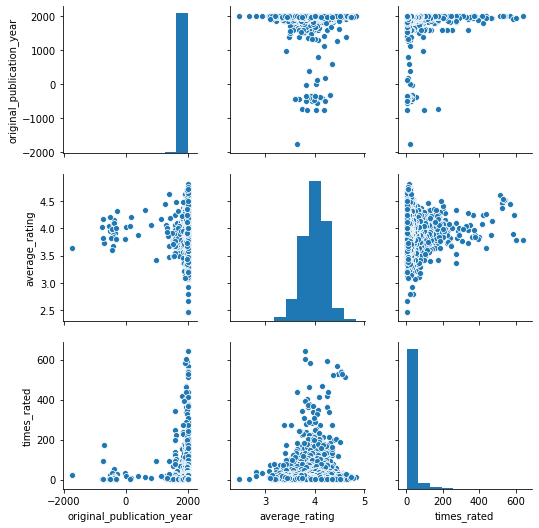

In [10]:
sns.pairplot(books_df)

### Generate correlation matrix

In [11]:
books_df.corr()

,original_publication_year,average_rating,times_rated
original_publication_year,1.000000,0.023625,-0.032335
average_rating,0.023625,1.000000,-0.030368
times_rated,-0.032335,-0.030368,1.000000


From the above we can see that `average_rating` and `times_rated` are positively correlated, meaning that one's increase means the other increases as well.

We can study the diagram more closely

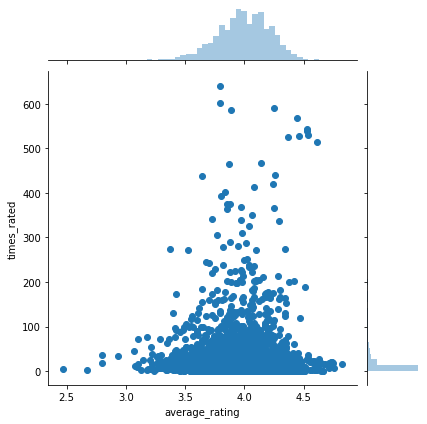

In [12]:
sns.jointplot(x='average_rating', y='times_rated', data=books_df)

We notice that the diagram has a small tendency/slope towards the top right corner. As such, when `times_rated` increases, so does the `average_rating` and vice versa

### Average_ratings histogram

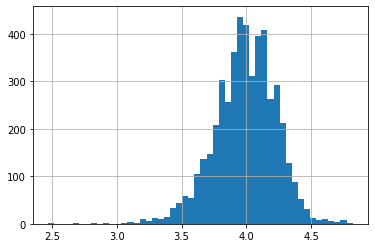

In [13]:
books_df["average_rating"].hist(bins=50)

As such, we see that most books are rating close to 4/5

### Times_rated histogram

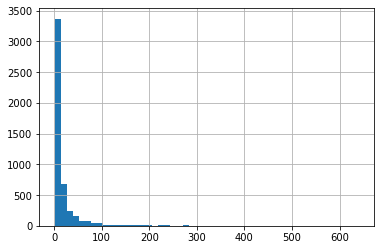

In [14]:
books_df["times_rated"].hist(bins=50)

Here we see that books aren't really rated more than ~200 times often

## Next, we build the book_matrix

In [15]:
book_matrix = ratings_df.pivot_table(index='user_id', columns='original_title', values='rating')
book_matrix.head()

original_title,Animal Farm & 1984,"Burned (Burned, #1)",Carter Beats the Devil,De Imitatione Christi,Faust. Der Tragödie erster und zweiter Teil,Feeling Good: The New Mood Therapy,Innocent Traitor,The Fellowship of the Ring,The Sea of Trolls,The Tale of Despereaux,...,神の子どもたちはみな踊る,窓ぎわのトットちゃん,羊をめぐる冒険 [Hitsujiwomegurubōken],美少女戦士セーラームーン 1 [Bishōjo Senshi Sailor Moon 1],花より男子 1,論語 [Lún Yǔ],象の消滅 [Zō no shōmetsu],道德經 [dào dé jīng],鋼の錬金術師 1,雪国
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Recommender system in full effect

### For examples' sake we pick from the most rated books

In [16]:
books_df.sort_values('times_rated', ascending=False).head(10)

,authors,original_publication_year,original_title,average_rating,image_url,times_rated
19,Dan Brown,2003.0,The Da Vinci Code,3.79,https://images.gr-assets.com/books/1303252999m...,641
5,J.D. Salinger,1951.0,The Catcher in the Rye,3.79,https://images.gr-assets.com/books/1398034300m...,602
2,Harper Lee,1960.0,To Kill a Mockingbird,4.25,https://images.gr-assets.com/books/1361975680m...,591
3,F. Scott Fitzgerald,1925.0,The Great Gatsby,3.89,https://images.gr-assets.com/books/1490528560m...,585
0,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,4.44,https://images.gr-assets.com/books/1474154022m...,569
12,"J.K. Rowling, Mary GrandPré, Rufus Beck",1999.0,Harry Potter and the Prisoner of Azkaban,4.53,https://images.gr-assets.com/books/1499277281m...,544
17,"J.K. Rowling, Mary GrandPré",2000.0,Harry Potter and the Goblet of Fire,4.53,https://images.gr-assets.com/books/1361482611m...,538
20,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,4.54,https://images.gr-assets.com/books/1361039191m...,530
14,"J.K. Rowling, Mary GrandPré",2003.0,Harry Potter and the Order of the Phoenix,4.46,https://images.gr-assets.com/books/1387141547m...,527
16,"J.K. Rowling, Mary GrandPré",1998.0,Harry Potter and the Chamber of Secrets,4.37,https://images.gr-assets.com/books/1474169725m...,525


Assuming our reader liked `The Catcher in the Rye` and `To Kill a Mockingbird`, we proceed to try to recommend him books similar to these

In [17]:
TCITR_rating = book_matrix['The Catcher in the Rye']
TKAM_rating = book_matrix['To Kill a Mockingbird']

In [18]:
TCITR_rating.head()

user_id
1    NaN
2    NaN
3    NaN
4    4.0
6    NaN
Name: The Catcher in the Rye, dtype: float64

In [19]:
TKAM_rating.head()

user_id
1    NaN
2    NaN
3    3.0
4    4.0
6    NaN
Name: To Kill a Mockingbird, dtype: float64

### Now that we've got the user ratings for these books, we try to correlate the ratings with other books (users who rated both books similarly) 

In [20]:
similar_to_TCITR = book_matrix.corrwith(TCITR_rating)
similar_to_TCITR.sort_values(ascending=False).head()

original_title
The Walking Dead, Vol. 4: The Heart's Desire    1.0
The Polar Express                               1.0
The Long Goodbye                                1.0
Pyramids                                        1.0
Surprised by Joy: The Shape of My Early Life    1.0
dtype: float64

In [21]:
similar_to_TKAM = book_matrix.corrwith(TKAM_rating)
similar_to_TKAM.sort_values(ascending=False).head()

original_title
The Monk Who Sold His Ferrari: A Fable About Fulfilling Your Dreams & Reaching Your Destiny    1.0
Reaper Man                                                                                     1.0
Second Treatise of Government                                                                  1.0
A Breath of Snow and Ashes                                                                     1.0
O Evangelho segundo Jesus Cristo                                                               1.0
dtype: float64

As we see, examples of similar books for TCITR include `A Tree Grows In Brooklyn` and `A Wizard of Earthsea`, while similar to TKAM are `One Flew Over the Cuckoo's Nest` and `Bookends` (assuming the full dataset - using a smaller dataset will result in different correlations)

### Tidy up

In [22]:
corr_TCITR = pd.DataFrame(similar_to_TCITR, columns=['correlation'])
corr_TCITR.dropna(inplace=True)
corr_TCITR.head()

,correlation
original_title,
Animal Farm & 1984,0.447214
De Imitatione Christi,1.000000
Faust. Der Tragödie erster und zweiter Teil,0.878310
The Fellowship of the Ring,0.088330
The Sea of Trolls,1.000000


In [23]:
corr_TKAM = pd.DataFrame(similar_to_TKAM, columns=['correlation'])
corr_TKAM.dropna(inplace=True)
corr_TKAM.head()

,correlation
original_title,
Animal Farm & 1984,-0.051209
De Imitatione Christi,-1.000000
Faust. Der Tragödie erster und zweiter Teil,-0.467707
The Fellowship of the Ring,-0.080501
The Sea of Trolls,-1.000000


### Now we're going to limit the correlated books based on the times they were rated

In [24]:
corr_TCITR = pd.merge(ratings_per_book[["original_title", "times_rated"]], corr_TCITR, right_index=True, left_on="original_title")
corr_TCITR.set_index('original_title', inplace=True, drop=True)
corr_TCITR.head()

,times_rated,correlation
original_title,,
Twilight,569,0.175062
To Kill a Mockingbird,45,0.191046
The Great Gatsby,591,0.298058
The Catcher in the Rye,365,1.000000
Angels & Demons,602,0.038376


In [25]:
corr_TKAM = pd.merge(ratings_per_book[["original_title", "times_rated"]], corr_TKAM, right_index=True, left_on="original_title")
corr_TKAM.set_index('original_title', inplace=True, drop=True)
corr_TKAM.head()

,times_rated,correlation
original_title,,
Twilight,569,-0.508024
To Kill a Mockingbird,45,1.000000
The Great Gatsby,591,0.301162
The Catcher in the Rye,365,0.191046
Angels & Demons,602,0.014980


### As we saw from the histogram, books rarely are rated more than ~200 times and as such that will be our threshold

In [31]:
corr_TCITR[corr_TCITR['times_rated'] > 200].sort_values(by='correlation', ascending=False).head(10)

,times_rated,correlation
original_title,,
The Catcher in the Rye,365,1.000000
Charlotte's Web,393,0.390688
My Sister's Keeper,238,0.332916
The Great Gatsby,591,0.298058
Lord of the Flies,530,0.291964
The Grapes of Wrath,221,0.288806
The Adventures of Huckleberry Finn,287,0.272297
"New Moon (Twilight, #2)",226,0.218218
An Excellent conceited Tragedie of Romeo and Juliet,437,0.214054


In [32]:
corr_TKAM[corr_TKAM['times_rated'] > 200].sort_values(by='correlation', ascending=False).head(10)

,times_rated,correlation
original_title,,
The Sisterhood of the Traveling Pants,222,0.541705
World War Z: An Oral History of the Zombie War,243,0.525226
Eldest,235,0.496031
Het Achterhuis: Dagboekbrieven 14 juni 1942 - 1 augustus 1944,465,0.358375
The Adventures of Huckleberry Finn,287,0.346364
Charlotte's Web,393,0.304380
The Great Gatsby,591,0.301162
The Firm,272,0.299539
An Excellent conceited Tragedie of Romeo and Juliet,437,0.273228


The Diary of a Young GirlUsing these correlation metrics we can recommend the user e.g `Charlotte's Web` and `The Diary of a Young Girl`or `The Sisterhood of the Traveling Pants`